# Setup and Data

In [ ]:
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt

# Parameters
start_year = 1997
end_year = 2022 
base_year = start_year
top_n = 20  # Number of top increases and decreases to display

# Load data
data_folder = 'Data_clean/'
primary_categories_path = data_folder + 'CPI_primary_categories.csv'
primary_categories_codebook_path = data_folder + 'CPI_primary_categories_codebook_english.csv'
primary_categories = pd.read_csv(primary_categories_path)
primary_categories_codebook = pd.read_csv(primary_categories_codebook_path)

# Clean only the 'Item' column and convert to integer
primary_categories['Item'] = primary_categories['Item'].map(lambda x: str(x)[:6] if isinstance(x, (int, float, str)) else x)
primary_categories['Item'] = primary_categories['Item'].astype(int)

# Create a dictionary mapping codes to descriptions from the codebook
code_to_description = dict(zip(primary_categories_codebook['Item'], primary_categories_codebook['Description']))

# Add description column by mapping codes to their descriptions
primary_categories['Description'] = primary_categories['Item'].map(code_to_description)

# Reorder columns to place Description right after Item
columns = primary_categories.columns.tolist()
columns.remove('Description')
item_index = columns.index('Item')
columns.insert(item_index + 1, 'Description')
primary_categories = primary_categories[columns]

# Filter data to keep only observations between start_year and end_year inclusive
primary_categories = primary_categories[(primary_categories['Year'] >= start_year) & (primary_categories['Year'] <= end_year)]

# Calculate the average of months 1 to 12 for each row
primary_categories['Yearly_Average'] = primary_categories[[str(month) for month in range(1, 13)]].mean(axis=1)

# Keep only yearly average for each year
primary_categories = primary_categories[['Item', 'Description', 'Year', 'Yearly_Average']]

# Create a new DataFrame with Item and Description as index
pivot_df = primary_categories.pivot(index=['Item', 'Description'], columns='Year', values='Yearly_Average')

# Reset index to make Item and Description regular columns
pivot_df = pivot_df.reset_index()

# Rename columns to be more descriptive
pivot_df.columns.name = None
year_columns = {year: f'{year}' for year in range(start_year, end_year + 1)}
pivot_df = pivot_df.rename(columns=year_columns)

# Replace primary_categories with the new pivoted DataFrame
primary_categories = pivot_df

# Drop rows with any missing values across all year columns
primary_categories = primary_categories.dropna(subset=[str(year) for year in range(start_year, end_year + 1)]).copy()

# Calculate the difference between end_year and start_year values
primary_categories.loc[:, f'Change_{start_year}_{end_year}'] = (
    primary_categories[str(end_year)] - primary_categories[str(start_year)])

# Get the top N largest increases and decreases
top_increases = primary_categories.nlargest(top_n, f'Change_{start_year}_{end_year}')
top_decreases = primary_categories.nsmallest(top_n, f'Change_{start_year}_{end_year}')

# Calculate the average of all observations for each year
yearly_averages = primary_categories[[str(year) for year in range(start_year, end_year + 1)]].mean().reset_index()
yearly_averages.columns = ['Year', 'Average_Price_Index']


# Output

In [ ]:
# Display the yearly averages as a table
print(f'Average Price Index for Each Year from {start_year} to {end_year}')
print(tabulate(yearly_averages, headers='keys', tablefmt='pretty'))
print('\n')

Average Price Index for Each Year from 1997 to 2022
+----+------+---------------------+
|    | Year | Average_Price_Index |
+----+------+---------------------+
| 0  | 1997 |  84.84172494172493  |
| 1  | 1998 |  88.0539627039627   |
| 2  | 1999 |  92.08449883449883  |
| 3  | 2000 |  92.40844988344989  |
| 4  | 2001 |  91.93059440559442  |
| 5  | 2002 |  93.01468531468532  |
| 6  | 2003 |  92.77418414918414  |
| 7  | 2004 |   91.741317016317   |
| 8  | 2005 |  91.5775641025641   |
| 9  | 2006 |  93.0368881118881   |
| 10 | 2007 |  93.34673659673658  |
| 11 | 2008 |  96.54294871794875  |
| 12 | 2009 |  96.92884615384615  |
| 13 | 2010 |  97.6011072261072   |
| 14 | 2011 |  100.7518648018648  |
| 15 | 2012 | 101.05378787878787  |
| 16 | 2013 | 102.11270396270396  |
| 17 | 2014 | 101.21066433566433  |
| 18 | 2015 |  99.84545454545456  |
| 19 | 2016 |  98.56136363636365  |
| 20 | 2017 |  97.74842657342658  |
| 21 | 2018 |  97.17663170163172  |
| 22 | 2019 |  97.25017482517482  |
| 23 | 2020 

In [3]:
# Display the top N increases and decreases as tables
top_increases[f'Change_{start_year}_{end_year}'] = top_increases[f'Change_{start_year}_{end_year}'].round(2)
top_decreases[f'Change_{start_year}_{end_year}'] = top_decreases[f'Change_{start_year}_{end_year}'].round(2)
print(f'Top {top_n} Price Increases from {start_year} to {end_year}')
print(tabulate(top_increases[['Description', f'Change_{start_year}_{end_year}']], headers='keys', tablefmt='pretty'))
print('\n')
print(f'Top {top_n} Price Decreases from {start_year} to {end_year}')
print(tabulate(top_decreases[['Description', f'Change_{start_year}_{end_year}']], headers='keys', tablefmt='pretty'))
print('\n')


Top 20 Price Increases from 1997 to 2022
+-----+-----------------------------------------------------+------------------+
|     |                     Description                     | Change_1997_2022 |
+-----+-----------------------------------------------------+------------------+
| 65  |        Kerosene and Diesel for Home Heating         |      90.09       |
| 145 |               Cigarettes and Tobacco                |      74.15       |
| 64  |                Gas for Household Use                |      68.21       |
| 143 |                   Postal Services                   |      65.94       |
| 28  |                      Margarine                      |      64.93       |
| 13  |                        Bread                        |      62.38       |
| 15  |                        Flour                        |      61.81       |
| 49  |                    Meals at Work                    |      60.59       |
| 20  |                        Beef                         |      6

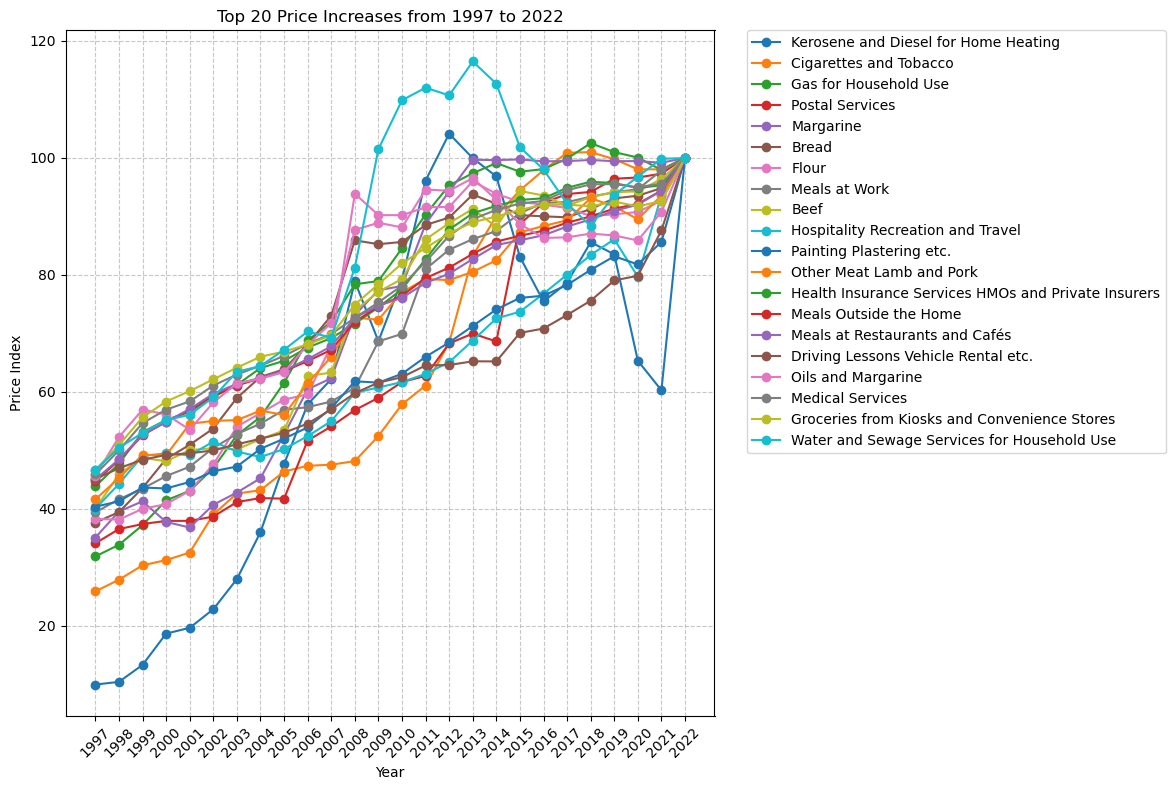

In [4]:
# Create a plot for the top N increases
plt.figure(figsize=(12, 8))
for idx, row in top_increases.iterrows():
    yearly_values = row[[str(year) for year in range(start_year, end_year + 1)]].values
    plt.plot(range(start_year, end_year + 1), yearly_values, marker='o', label=row['Description'])

plt.title(f'Top {top_n} Price Increases from {start_year} to {end_year}')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(range(start_year, end_year + 1), rotation=45)
plt.tight_layout()
plt.show()

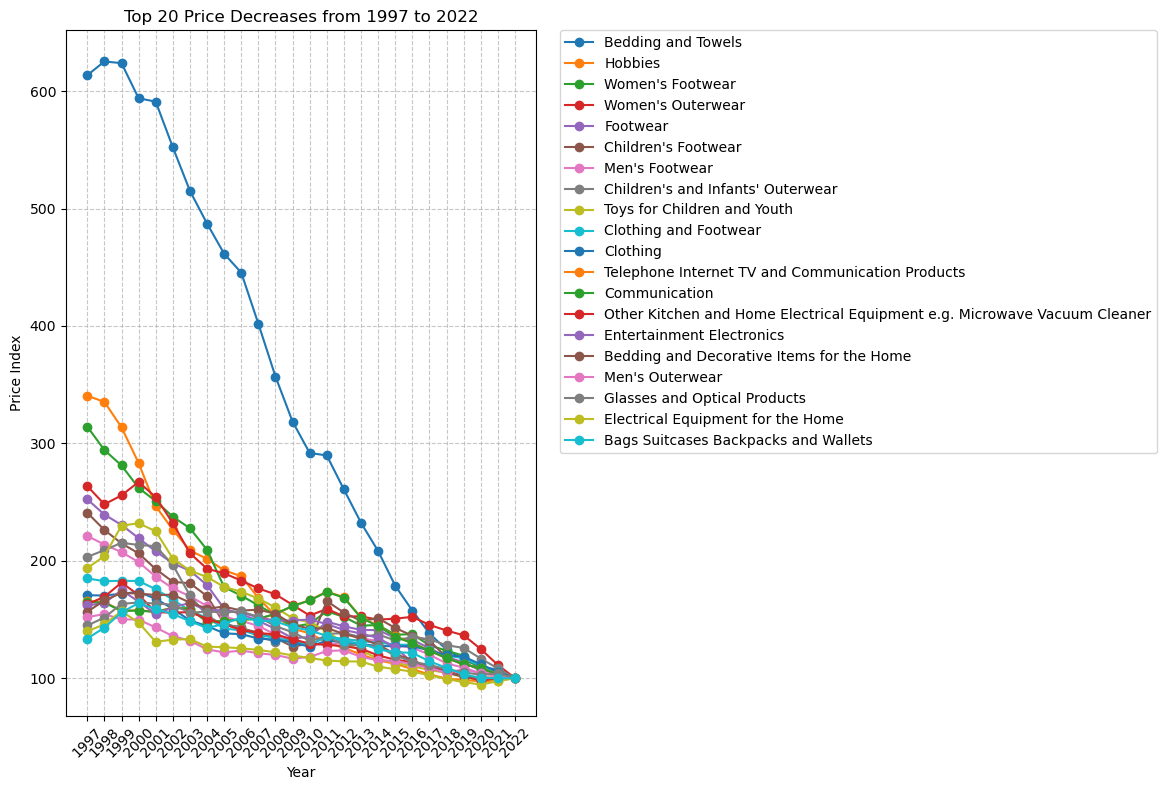

In [5]:
# Create a plot for the top N decreases
plt.figure(figsize=(12, 8))
for idx, row in top_decreases.iterrows():
    yearly_values = row[[str(year) for year in range(start_year, end_year + 1)]].values
    plt.plot(range(start_year, end_year + 1), yearly_values, marker='o', label=row['Description'])

plt.title(f'Top {top_n} Price Decreases from {start_year} to {end_year}')
plt.xlabel('Year')
plt.ylabel('Price Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xticks(range(start_year, end_year + 1), rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Export to pdf
!jupyter nbconvert --to pdf --no-input CPI_top_changes.ipynb

[NbConvertApp] Converting notebook CPI_top_changes.ipynb to pdf
[NbConvertApp] Support files will be in CPI_top_changes_files/
[NbConvertApp] Making directory ./CPI_top_changes_files
[NbConvertApp] Writing 25816 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 412213 bytes to CPI_top_changes.pdf
